In [1]:
gene_proteins <- read.csv("C:/Users/Nandini/Desktop/minor/PAM50_proteins.csv")
clinical <- read.csv("C:/Users/Nandini/Desktop/minor/clinical_data_breast_cancer.csv")
proteomes <- read.csv("C:/Users/Nandini/Desktop/minor/77_cancer_proteomes_CPTAC_itraq.csv")

In [2]:
n <- proteomes$RefSeq_accession_number 
proteomes <- as.data.frame(t(proteomes[,4:86]))
colnames(proteomes) <- n
proteomes <- cbind(rownames(proteomes), data.frame(proteomes, row.names=NULL))
colnames(proteomes)[1] <- "Complete.TCGA.ID"

In [3]:
get.clinical.id <- function(proteome.id) {
  x = substr(proteome.id, 4, 7)
  y = substr(proteome.id, 0, 2)
  paste("TCGA",y,x,sep="-")
}
proteomes$Complete.TCGA.ID <- sapply(proteomes$Complete.TCGA.ID, get.clinical.id)
proteomes_all <- proteomes

[1] 2251

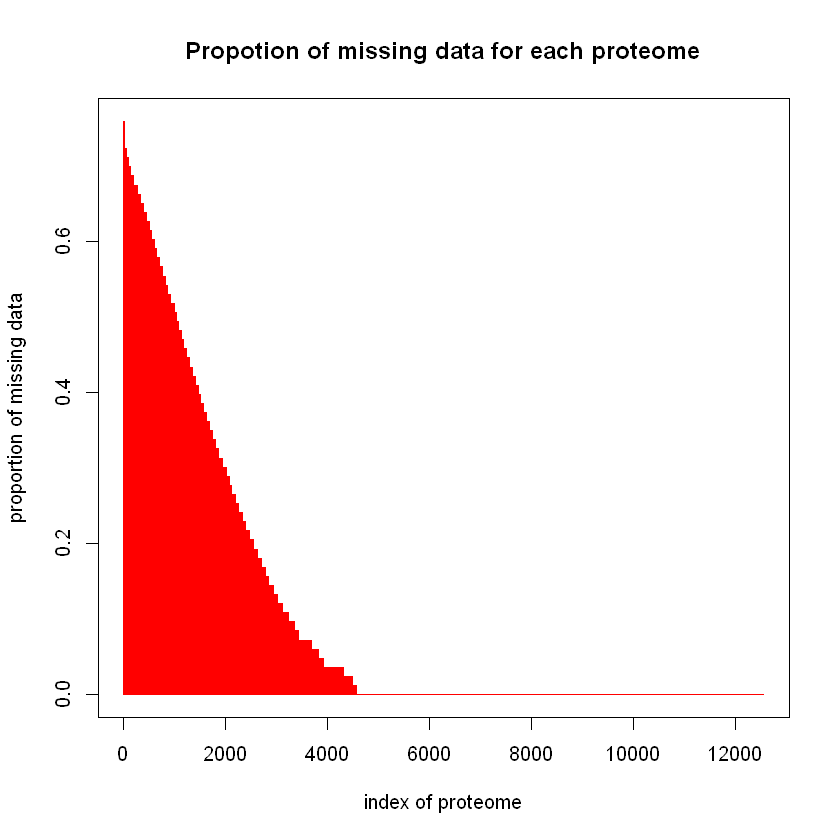

In [4]:
naCounts <- colSums(is.na(proteomes)) / nrow(proteomes)
plot(sort(naCounts, decreasing = TRUE), col ="red", type = 'h', xlab = "index of proteome", ylab="proportion of missing data", main = "Propotion of missing data for each proteome") 
length(naCounts[naCounts>0.25])

In [5]:
proteomes <- proteomes[ , colSums(is.na(proteomes))  / nrow(proteomes) < 0.25] 
for (i in which(sapply(proteomes, is.numeric))) {
    proteomes[is.na(proteomes[, i]), i] <- mean(proteomes[, i],  na.rm = TRUE)
}

In [6]:
library(dplyr)
setwd("C:/Users/Nandini/Desktop/minor")
data <-  inner_join(clinical, proteomes, by = "Complete.TCGA.ID")
colnames(data)[3] <- "diag_age"
write.csv(data,file="minor.csv",row.names=FALSE)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"Column `Complete.TCGA.ID` joining factor and character vector, coercing into character vector"

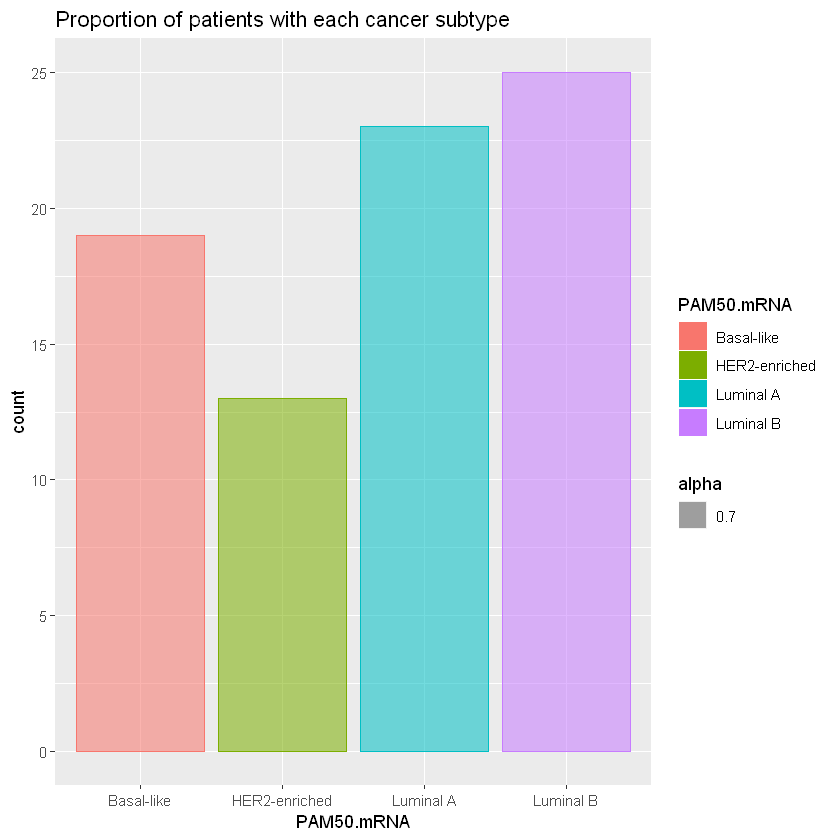

In [7]:
library(ggplot2)
ggplot(data, aes(PAM50.mRNA, col = PAM50.mRNA, fill = PAM50.mRNA, alpha=0.7)) + geom_bar() + ggtitle("Proportion of patients with each cancer subtype")

In [8]:
library(lattice)
set.seed(1)
library(caret)
samp <- createDataPartition(data$PAM50.mRNA, p = 0.7, list = FALSE)

In [9]:
library(Matrix)
library(foreach)
options(warn = -1)
library(glmnet)
LassoSub=function(k=1, Xdata, Ydata){
  set.seed(k)
  s=sample(nrow(data), size=0.8*nrow(data))
  Xsub=Xdata[s, ]
  Ysub=Ydata[s]
  model.sub=cv.glmnet(x=Xsub, y=Ysub, alpha=1, family="multinomial") 
  coef.sub=coef(model.sub, s='lambda.1se')[-1] 
  return(coef.sub)
}

Loaded glmnet 2.0-16



In [10]:
lasso.stab=sapply(1:100, FUN=LassoSub, Xdata=as.matrix(data[,31:ncol(data)]), Ydata=as.matrix(data[,21]))

In [14]:
ncol(data)

[1] 10332

In [15]:
nrow(data)

[1] 80

In [16]:
stability_matrix <- matrix(nrow=length(lasso.stab[[1]]),ncol=length(lasso.stab))
rownames(stability_matrix) <- rownames(lasso.stab[[1]])
for (i in 1:300){
  temp.data.frame <- as.matrix(lasso.stab[[i]])
  stability_matrix[,i] <- temp.data.frame
}
stability_matrix <- ifelse(stability_matrix != 0, 1, 0) 
stability_matrix <- stability_matrix[2:nrow(stability_matrix),] 
stable_variables <- as.data.frame(rowSums(stability_matrix))
stable_variables$protein <- rownames(stable_variables)
colnames(stable_variables)[1] <- "times_selected" 
stable_variables[!is.na(stable_variables$times_selected),] 
stable_variables <- stable_variables[stable_variables$times_selected != 0,] 
stable_variables <- stable_variables[order(-stable_variables$times_selected),] 

,times_selected,protein
NP_958782,0,NP_958782
NP_958785,0,NP_958785
NP_958786,0,NP_958786
NP_000436,0,NP_000436
NP_958781,0,NP_958781
NP_958780,0,NP_958780
NP_958783,0,NP_958783
NP_958784,0,NP_958784
NP_112598,0,NP_112598
NP_001611,0,NP_001611


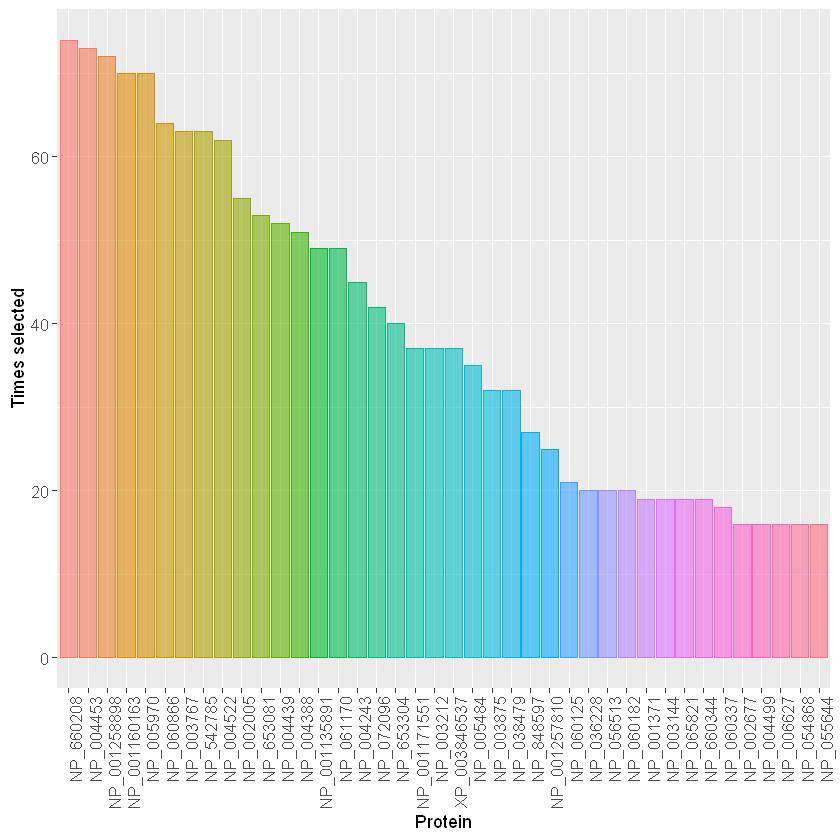

In [17]:
ggplot(stable_variables[1:40,], aes(x=reorder(as.factor(protein),-abs(times_selected),mean), y=times_selected, col =reorder(as.factor(protein),-abs(times_selected),mean), fill =reorder(as.factor(protein),-abs(times_selected),mean))) + geom_col(show.legend = FALSE, alpha = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1), axis.text=element_text(size=10)) + xlab("Protein") + ylab("Times selected")
STABVARS <- stable_variables$protein[1:40]
STABVARS.ind <- which(colnames(data) %in% STABVARS)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



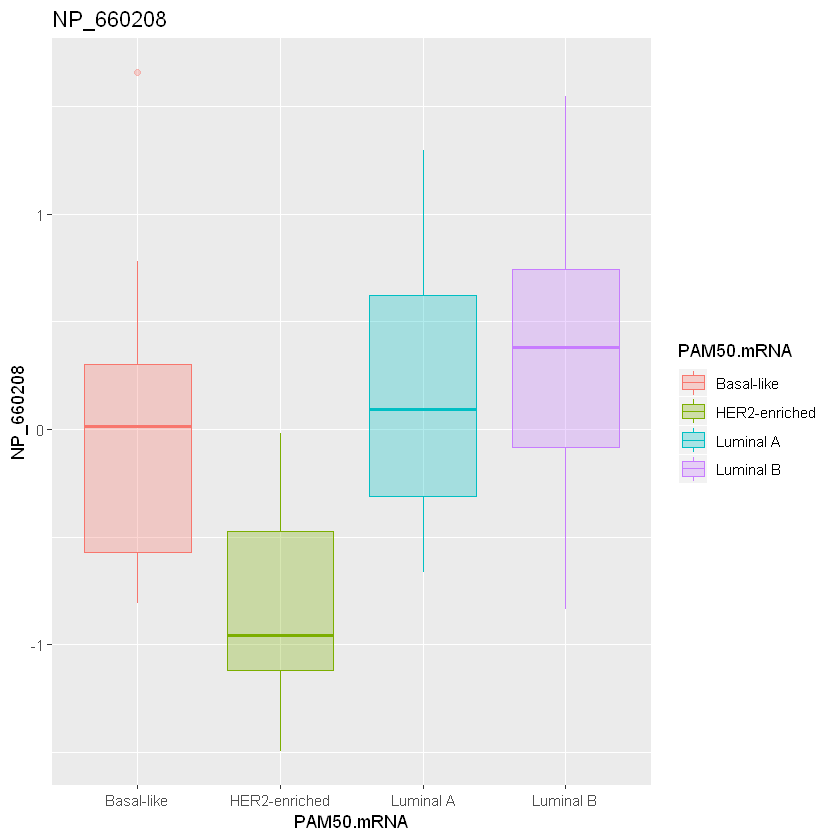

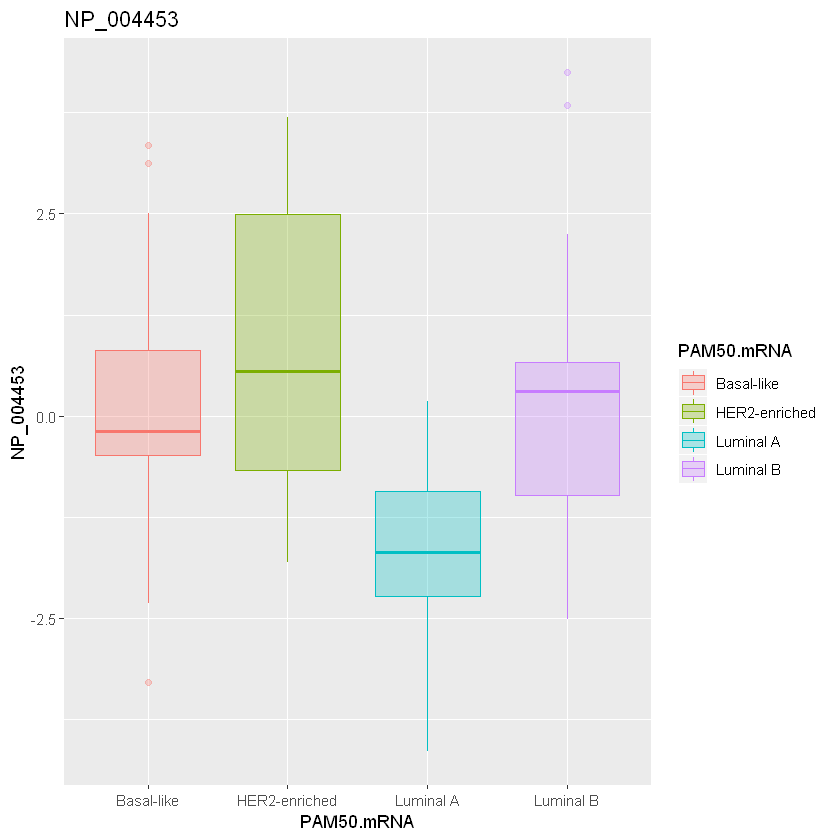

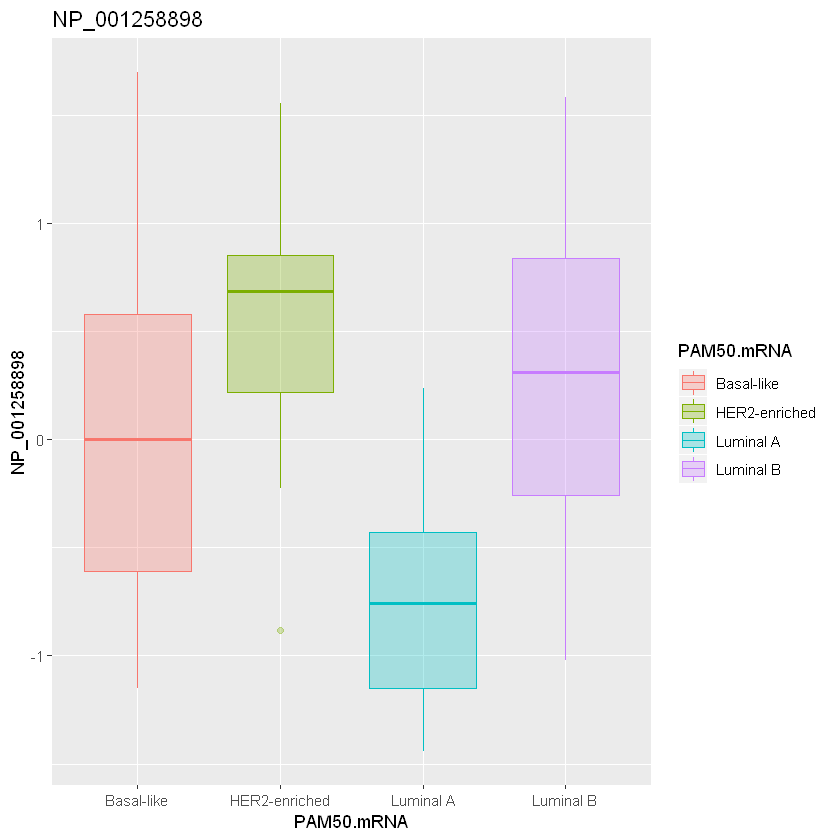

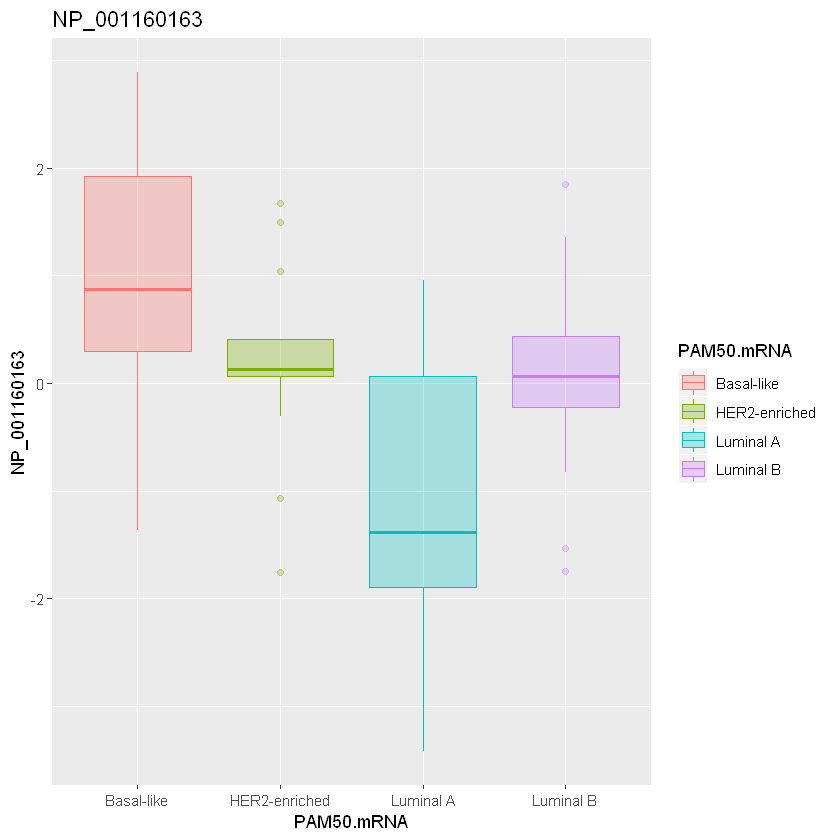

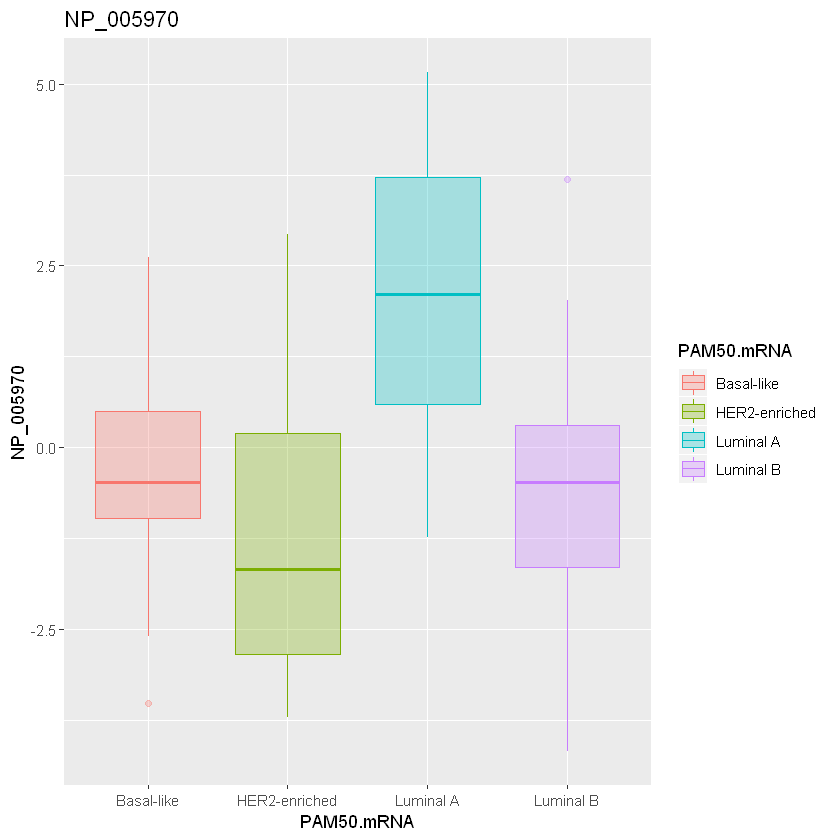

In [18]:
library(gridExtra)
for (i in 1:length(STABVARS[1:5])){
print(ggplot(data, aes_string("PAM50.mRNA", STABVARS[i], col="PAM50.mRNA", fill="PAM50.mRNA")) + geom_boxplot(alpha=0.3) + ggtitle(STABVARS[i]))
}

In [20]:
write.csv(data[, c(16, STABVARS.ind)],file="vital.csv",row.names=FALSE)

In [21]:
set.seed(1)
train_control <- trainControl(method="repeatedcv", number=3, repeats=10, savePredictions = TRUE, summaryFunction = multiClassSummary) 
grid <- expand.grid(C = seq(0.000001,0.15,0.002))

set.seed(1)
svm.lin.mod <- train(PAM50.mRNA ~ ., data=data[samp, c(21, STABVARS.ind)], trControl=train_control, method="svmLinear", preProcess = c("center","scale"), tuneGrid =grid, tuneLength = 10)
svm.predicts <- predict(svm.lin.mod, newdata = data[-samp, c(21, STABVARS.ind)])

confusionMatrix(svm.predicts, data$PAM50.mRNA[-samp])

Confusion Matrix and Statistics

               Reference
Prediction      Basal-like HER2-enriched Luminal A Luminal B
  Basal-like             4             0         0         1
  HER2-enriched          1             3         0         0
  Luminal A              0             0         5         1
  Luminal B              0             0         1         5

Overall Statistics
                                          
               Accuracy : 0.8095          
                 95% CI : (0.5809, 0.9455)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 1.026e-05       
                                          
                  Kappa : 0.7423          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Basal-like Class: HER2-enriched Class: Luminal A
Sensitivity                     0.8000               1.0000           0.8333
Specificity                     0.9375               0.9444           0.9333
Pos Pred Value     

In [23]:
overall_svm  <- confusionMatrix(svm.predicts, data$PAM50.mRNA[-samp])
print(paste(paste("Overall accuracy is", round(overall_svm$overall[1],3)*100),"%"))

[1] "Overall accuracy is 81 %"


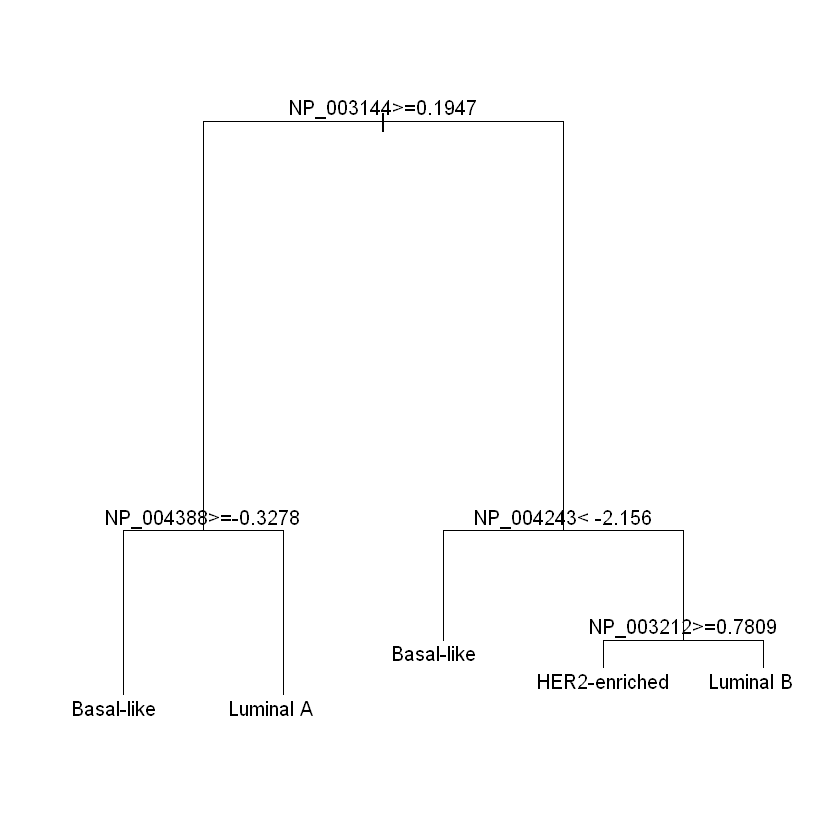

In [24]:
set.seed(123)
library(rpart)
model_rpart <- rpart(PAM50.mRNA ~ ., data = data[samp, c(21, STABVARS.ind)], method = "class")
# Plot the trees
par(xpd = NA) # Avoid clipping the text in some device
plot(model_rpart)
text(model_rpart, digits = 3)


In [25]:
predicted.classes <- model_rpart %>% 
  predict(newdata = data[-samp, c(21, STABVARS.ind)], type = "class")
head(predicted.classes)


11            12            16            17            19 
   Basal-like HER2-enriched    Basal-like    Basal-like    Basal-like 
           22 
    Luminal A 
Levels: Basal-like HER2-enriched Luminal A Luminal B

In [26]:
confusionMatrix(data$PAM50.mRNA[-samp],predicted.classes)

Confusion Matrix and Statistics

               Reference
Prediction      Basal-like HER2-enriched Luminal A Luminal B
  Basal-like             4             1         0         0
  HER2-enriched          1             1         1         0
  Luminal A              5             0         1         0
  Luminal B              0             0         1         6

Overall Statistics
                                          
               Accuracy : 0.5714          
                 95% CI : (0.3402, 0.7818)
    No Information Rate : 0.4762          
    P-Value [Acc > NIR] : 0.256           
                                          
                  Kappa : 0.4185          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Basal-like Class: HER2-enriched Class: Luminal A
Sensitivity                     0.4000              0.50000          0.33333
Specificity                     0.9091              0.89474          0.72222
Pos Pred Value     

In [27]:
overall_cart  <- confusionMatrix(data$PAM50.mRNA[-samp],predicted.classes)
print(paste(paste("Overall accuracy is", round(mean(predicted.classes == data$PAM50.mRNA[-samp]),3)*100),"%"))

[1] "Overall accuracy is 57.1 %"


In [36]:
set.seed(12)
#Training the knn model
model_knn<-train(data=data[samp, c(21, STABVARS.ind)],PAM50.mRNA ~ .,method='knn',trControl=train_control,tuneLength=3)

testSet_knn<-data[-samp,]
#Predicting using knn model
testSet_knn$pred_knn<-predict(object = model_knn,newdata = data[-samp, c(21, STABVARS.ind)])

#Checking the accuracy of the random forest model
confusionMatrix(data$PAM50.mRNA[-samp],testSet_knn$pred_knn)


Confusion Matrix and Statistics

               Reference
Prediction      Basal-like HER2-enriched Luminal A Luminal B
  Basal-like             5             0         0         0
  HER2-enriched          0             3         0         0
  Luminal A              0             0         6         0
  Luminal B              0             0         2         5

Overall Statistics
                                          
               Accuracy : 0.9048          
                 95% CI : (0.6962, 0.9883)
    No Information Rate : 0.381           
    P-Value [Acc > NIR] : 9.309e-07       
                                          
                  Kappa : 0.8704          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Basal-like Class: HER2-enriched Class: Luminal A
Sensitivity                     1.0000               1.0000           0.7500
Specificity                     1.0000               1.0000           1.0000
Pos Pred Value     

In [37]:
overall_knn  <- confusionMatrix(data$PAM50.mRNA[-samp],testSet_knn$pred_knn)
print(paste(paste("Overall accuracy is", round(overall_knn$overall[1],3)*100),"%"))

[1] "Overall accuracy is 90.5 %"


In [38]:
#Training the random forest model
set.seed(23)
model_rf<-train(data=data[samp, c(21, STABVARS.ind)],PAM50.mRNA ~ .,method='rf',trControl=train_control,tuneLength=3)
testSet<-data[-samp,]
#Predicting using random forest model
testSet$pred_rf<-predict(object = model_rf,newdata = data[-samp, c(21, STABVARS.ind)])
confusionMatrix(data$PAM50.mRNA[-samp],testSet$pred_rf)

Confusion Matrix and Statistics

               Reference
Prediction      Basal-like HER2-enriched Luminal A Luminal B
  Basal-like             4             0         0         1
  HER2-enriched          0             3         0         0
  Luminal A              0             0         5         1
  Luminal B              0             0         1         6

Overall Statistics
                                          
               Accuracy : 0.8571          
                 95% CI : (0.6366, 0.9695)
    No Information Rate : 0.381           
    P-Value [Acc > NIR] : 9.94e-06        
                                          
                  Kappa : 0.8031          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Basal-like Class: HER2-enriched Class: Luminal A
Sensitivity                     1.0000               1.0000           0.8333
Specificity                     0.9412               1.0000           0.9333
Pos Pred Value     

In [39]:
overall_rf  <- confusionMatrix(data$PAM50.mRNA[-samp],testSet$pred_rf)
print(paste(paste("Overall accuracy is", round(overall_rf$overall[1],3)*100),"%"))

[1] "Overall accuracy is 85.7 %"


In [40]:
set.seed(1)
library(randomForest)
fit_rf = randomForest(PAM50.mRNA~., data=data[samp, c(21, STABVARS.ind)])
# Create an importance based on mean decreasing gini
imp<-importance(fit_rf)
predictors<-as.vector(rownames(imp))
predictors

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



[1] "NP_038479"    "NP_001258898" "NP_542785"    "NP_065821"    "NP_055644"   
 [6] "NP_001371"    "NP_002005"    "XP_003846537" "NP_660208"    "NP_004439"   
[11] "NP_036228"    "NP_004388"    "NP_004243"    "NP_003144"    "NP_001171551"
[16] "NP_054868"    "NP_072096"    "NP_005484"    "NP_056513"    "NP_061170"   
[21] "NP_653304"    "NP_653081"    "NP_060125"    "NP_006627"    "NP_004453"   
[26] "NP_060337"    "NP_001257810" "NP_003212"    "NP_060866"    "NP_001160163"
[31] "NP_004499"    "NP_003875"    "NP_002677"    "NP_001135891" "NP_004522"   
[36] "NP_003767"    "NP_848597"    "NP_005970"    "NP_060182"    "NP_660344"

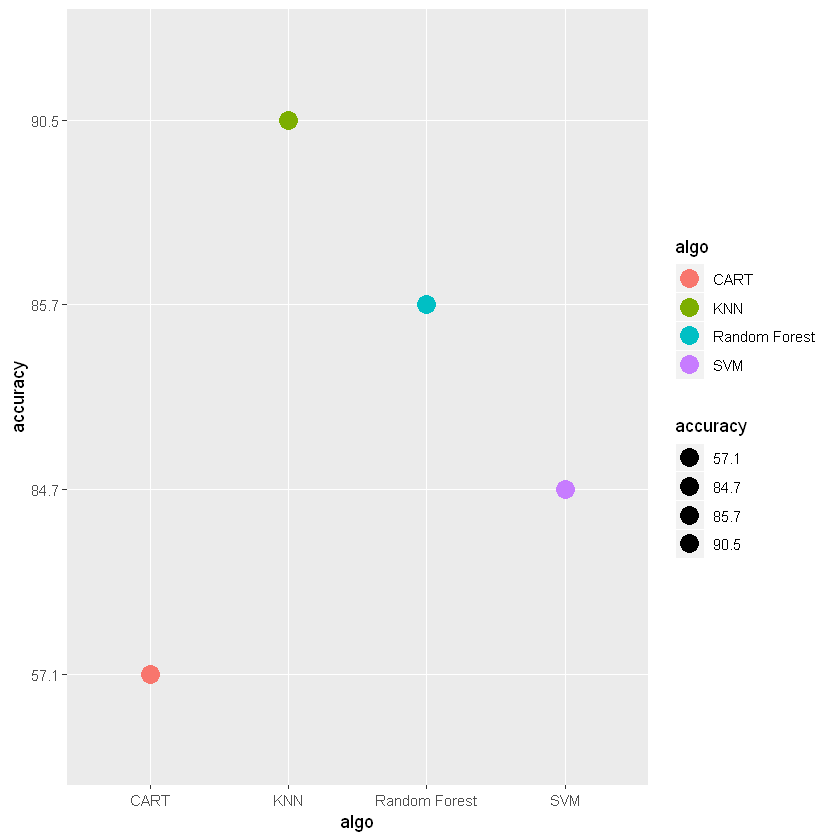

In [41]:
algo<-c("SVM","CART","KNN","Random Forest")
accuracy<-c("84.7","57.1","90.5","85.7")
x <- data.frame("algo" = algo, "accuracy" = accuracy)

library(ggplot2)
ggplot(x, aes(algo, accuracy, colour = algo , fill=accuracy)) + 
  geom_point(size=5)
